In [2]:
import torch 
import random
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("..")

from forecaster import Forecaster, PatchFMConfig, plot_forecast

In [4]:
# --- Instantiate model ---
config = PatchFMConfig()
config.ckpt_path = "../ckpts/pretrained_patchfm_artificial.pth"

model = Forecaster(config)

# Forecasting

In [3]:
# --- Load an artificial dataset ---
dataset = torch.load("../data/full.pt") # approx 40sec to load

/tmp/ipykernel_170632/2469717479.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load("../data/full.pt") # approx 40sec to load


Context shape: torch.Size([1, 1024]), Target shape: torch.Size([32])


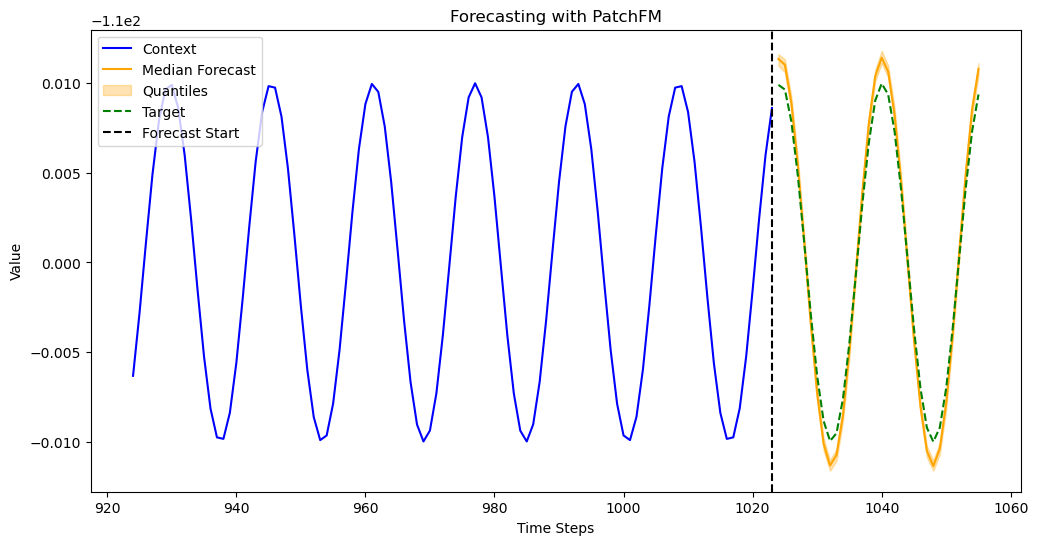

In [47]:
idx = random.randint(0, len(dataset))
context, target = dataset[idx]
xx = torch.cat([context, target], dim=0)

context_size = 1024
forecast_horizon = 32
context_plot_limit = 100

context = xx[:context_size].unsqueeze(0)
target = xx[context_size:forecast_horizon + context_size]

print(f"Context shape: {context.shape}, Target shape: {target.shape}")

pred_median, pred_quantiles = model(context, forecast_horizon=forecast_horizon, quantiles=[0.1, 0.5, 0.9])

plot_forecast(context, pred_median, pred_quantiles, target_pred=target, context_plot_limit=context_plot_limit)

# Anomaly Detection

In [3]:
from anomaly_detection.dataset_example import get_data

test = get_data(window_size=1024, root_dir='../anomaly_detection/', dataset="nyc_taxi")

In [4]:
scores = []

for x, y in test:
    score = model.anomaly_scorer(x)
    scores.append(score)

In [5]:
values  = [x[0][-1].squeeze().numpy().item() for x in test]
labels  = [x[1] for x in test]

In [6]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(labels, scores)
print(f"AUC: {auc:.4f}")

AUC: 0.7101


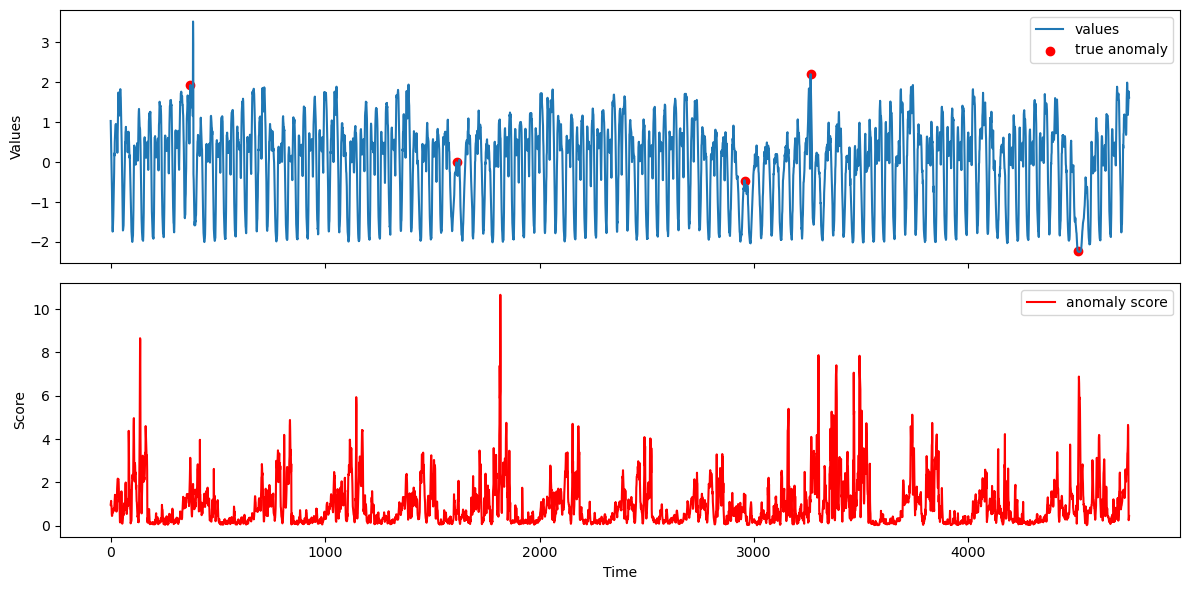

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# --- First plot: values + anomalies ---
ax1.plot(range(len(values)), values, label="values")
ax1.scatter(
    [i for i in range(len(values)) if labels[i] == 1],
    [values[i] for i in range(len(values)) if labels[i] == 1],
    color='red', label="true anomaly"
)
ax1.legend()
ax1.set_ylabel("Values")

threshold = np.percentile(scores, 99)
clipped_scores = np.clip(scores, None, threshold)

ax2.plot(range(len(clipped_scores)), scores, label="anomaly score", color='red')
ax2.legend()
ax2.set_xlabel("Time")
ax2.set_ylabel("Score")

plt.tight_layout()
plt.show()